In [10]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import seaborn as sns

In [2]:
df = pd.read_csv('air_dataset.csv')
df.drop(columns='Unnamed: 0',inplace=True)
class_name = 'weekend'

In [5]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [6]:
res = prepare_dataset(df, class_name)
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


## Data partitioning

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score

In [8]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

## Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

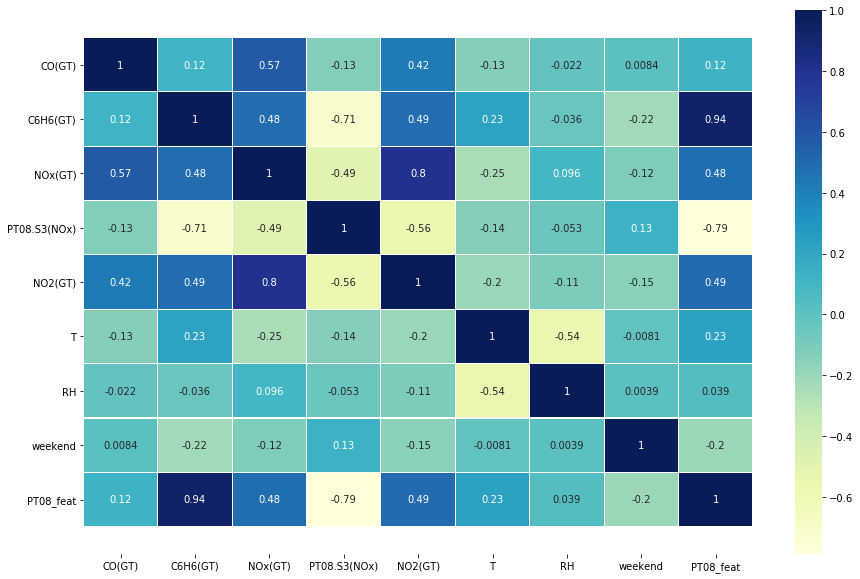

In [11]:
#Correlation Pearson (linear correlation)
plt.subplots(figsize=(15,10))
ax = sns.heatmap(df.corr(), annot = True, linewidth=0.1, cmap='YlGnBu')
#To fix matplot error
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
##
plt.show()

In [13]:
attributes = [col for col in df.columns if col == 'PT08_feat']
X = df[attributes].values
y = df['C6H6(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


In [17]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [0.02546746]
Intercept: 
 -18.951192062471275


In [19]:
y_pred = reg.predict(X_test)

In [20]:
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.878
MSE: 7.343
MAE: 1.952


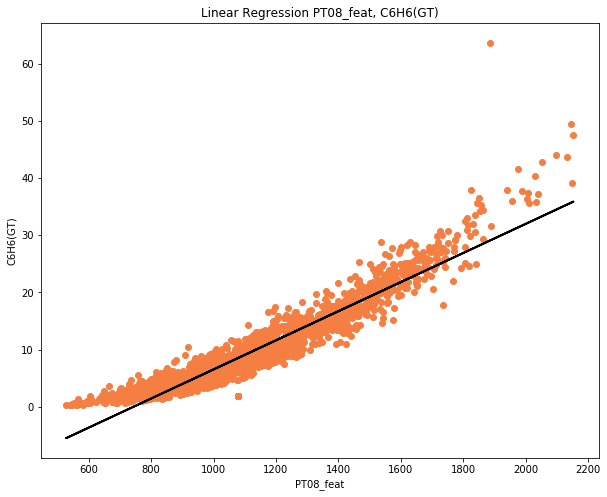

In [23]:
plt.figure(figsize=(10,8))
plt.scatter(X_test, y_test, color='#f57e42')
plt.plot(X_test, y_pred, color='black', linewidth=2)
plt.title('Linear Regression PT08_feat, C6H6(GT)')
plt.xlabel('PT08_feat')
plt.ylabel('C6H6(GT)')
plt.show()

## altri attributi

In [24]:
attributes = [col for col in df.columns if col == 'NO2(GT)']
X = df[attributes].values
y = df['NOx(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [25]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [4.21528352]
Intercept: 
 -267.06855313395135


In [27]:
y_pred = reg.predict(X_test)

In [28]:
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.643
MSE: 23819.123
MAE: 123.116


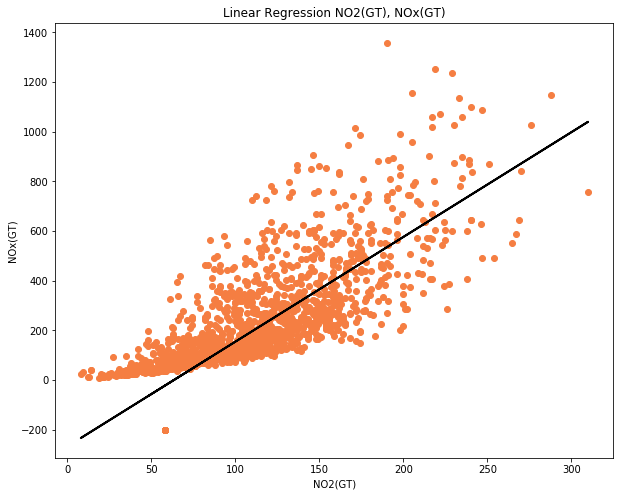

In [29]:
plt.figure(figsize=(10,8))
plt.scatter(X_test, y_test, color='#f57e42')
plt.plot(X_test, y_pred, color='black', linewidth=2)
plt.title('Linear Regression NO2(GT), NOx(GT)')
plt.xlabel('NO2(GT)')
plt.ylabel('NOx(GT)')
plt.show()

In [ ]:
## ALTRO

In [30]:
attributes = [col for col in df.columns if col == 'PT08_feat']
X = df[attributes].values
y = df['PT08.S3(NOx)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


In [31]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [-0.72504753]
Intercept: 
 1650.1485359446133


In [33]:
y_pred = reg.predict(X_test)

In [34]:
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.634
MSE: 23825.565
MAE: 113.478


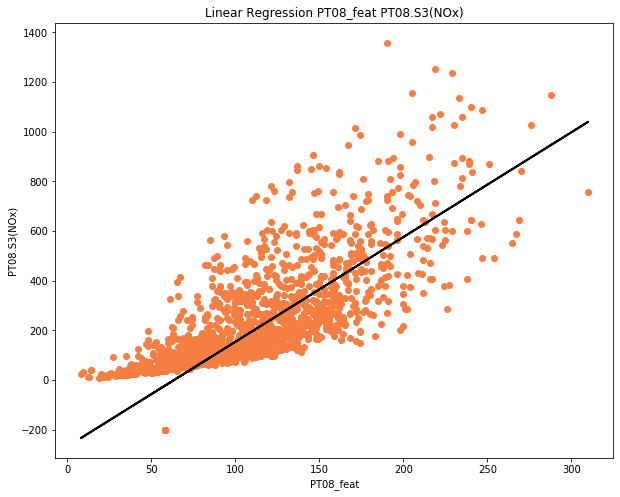

In [68]:
plt.figure(figsize=(10,8))
plt.scatter(X_test, y_test, color='#f57e42')
plt.plot(X_test, y_pred, color='black', linewidth=2)
plt.title('Linear Regression PT08_feat PT08.S3(NOx)')
plt.xlabel('PT08_feat')
plt.ylabel('PT08.S3(NOx)')
plt.show()

## Multiple linear regression

In [36]:
attributes = [col for col in df.columns if col == 'PT08_feat' or col == 'NO2(GT)']
X = df[attributes].values
y = df['C6H6(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [37]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [0.00562379 0.02496931]
Intercept: 
 -18.97314697905514


In [38]:
y_pred = reg.predict(X_test)

In [39]:
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.878
MSE: 7.313
MAE: 1.928


In [41]:
## LE PERFORMANCE RIMANGONO UGUALI RISPETTO AGLI ATTRIBUTI PIE' CORRELATI R2: 0.878 MSE: 7.343 MAE: 1.952

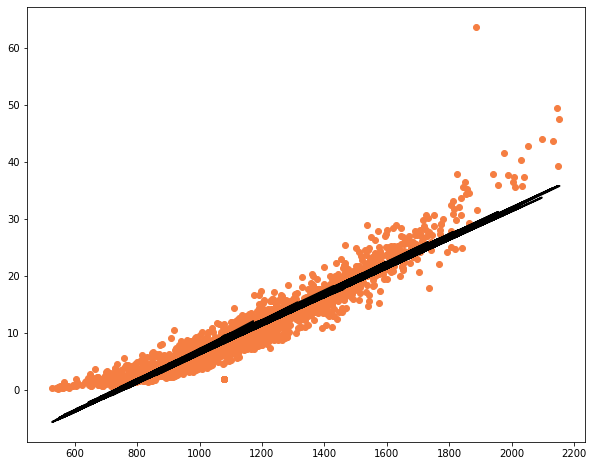

In [44]:
plt.figure(figsize=(10,8))
plt.scatter(X_test[:,1], y_test, color='#f57e42')
plt.plot(X_test[:,1], y_pred, color='black', linewidth=2)
plt.show()

In [45]:
#altro tentativo

In [46]:
attributes = [col for col in df.columns if col == 'NO2(GT)' or col == 'RH']
X = df[attributes].values
y = df['NOx(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [47]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [4.31775391 2.77084338]
Intercept: 
 -413.2982832678726


In [61]:
y_pred = reg.predict(X_test)

In [62]:
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.643
MSE: 23819.123
MAE: 123.116


In [50]:
#qui è leggermente migliorato

# RIDGE

In [52]:
attributes = [col for col in df.columns if col == 'PT08_feat']
X = df[attributes].values
y = df['C6H6(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [59]:
reg = Ridge()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [4.21528328]
Intercept: 
 -267.0685287152821


In [63]:
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.643
MSE: 23819.123
MAE: 123.116


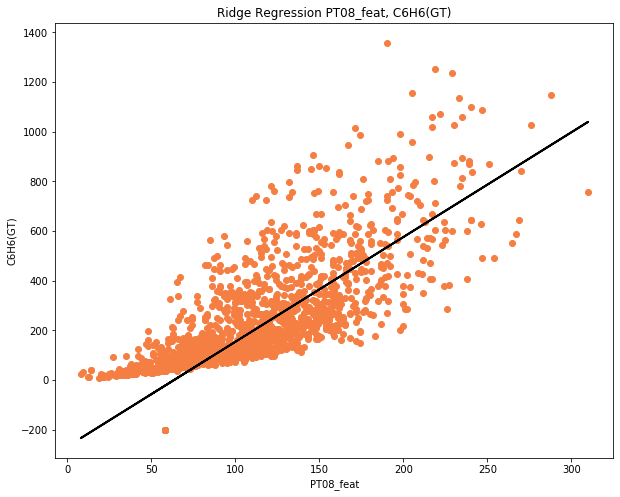

In [64]:
plt.figure(figsize=(10,8))
plt.scatter(X_test, y_test, color='#f57e42')
plt.plot(X_test, y_pred, color='black', linewidth=2)
plt.title('Ridge Regression PT08_feat, C6H6(GT)')
plt.xlabel('PT08_feat')
plt.ylabel('C6H6(GT)')
plt.show()

In [69]:
#Ridge 2

In [70]:
attributes = [col for col in df.columns if col == 'NO2(GT)']
X = df[attributes].values
y = df['NOx(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

Coefficients: 
 [4.21528328]
Intercept: 
 -267.0685287152821
R2: 0.643
MSE: 23819.123
MAE: 123.116


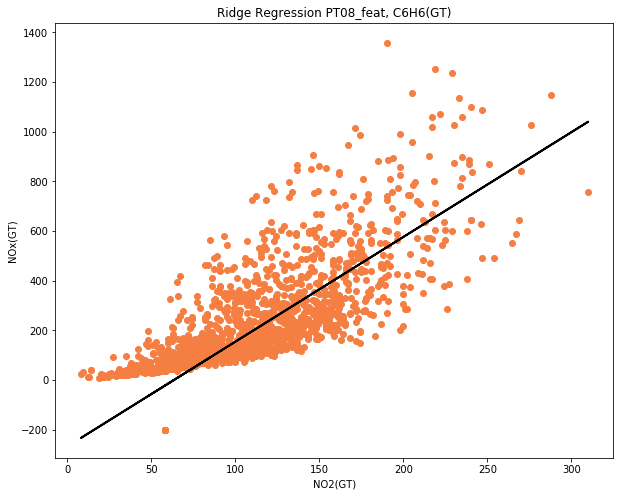

In [71]:
reg = Ridge()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))
plt.figure(figsize=(10,8))
plt.scatter(X_test, y_test, color='#f57e42')
plt.plot(X_test, y_pred, color='black', linewidth=2)
plt.title('Ridge Regression PT08_feat, C6H6(GT)')
plt.xlabel('NO2(GT)')
plt.ylabel('NOx(GT)')
plt.show()


# LASSO

Coefficients: 
 [0.02545394]
Intercept: 
 -18.935984761705658
R2: -1061.167
MSE: 63805.939
MAE: 186.090


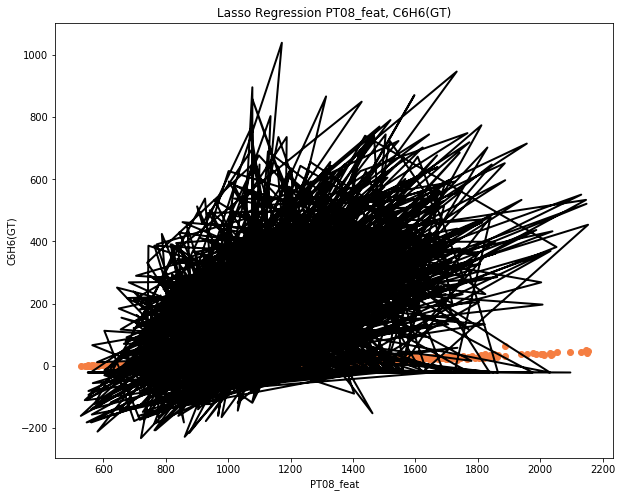

In [77]:
attributes = [col for col in df.columns if col == 'PT08_feat']
X = df[attributes].values
y = df['C6H6(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
reg = Lasso()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))
plt.figure(figsize=(10,8))
plt.scatter(X_test, y_test, color='#f57e42')
plt.plot(X_test, y_pred, color='black', linewidth=2)
plt.title('Lasso Regression PT08_feat, C6H6(GT)')
plt.xlabel('PT08_feat')
plt.ylabel('C6H6(GT)')
plt.show()

Coefficients: 
 [4.21486464]
Intercept: 
 -267.0251933599561
R2: 0.643
MSE: 23819.123
MAE: 123.116


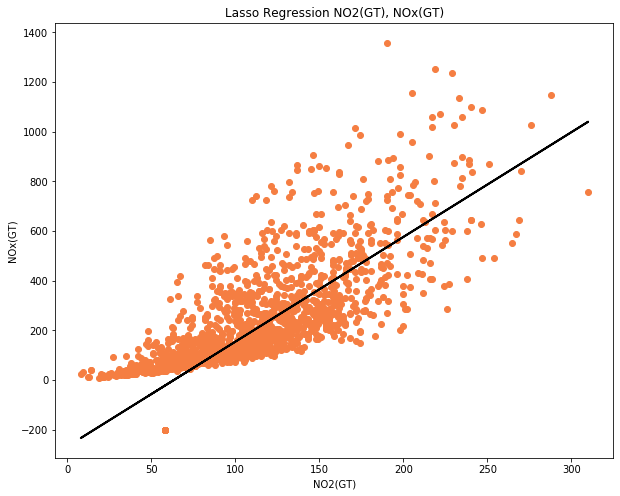

In [75]:
attributes = [col for col in df.columns if col == 'NO2(GT)']
X = df[attributes].values
y = df['NOx(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
reg = Lasso()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))
plt.figure(figsize=(10,8))
plt.scatter(X_test, y_test, color='#f57e42')
plt.plot(X_test, y_pred, color='black', linewidth=2)
plt.title('Lasso Regression NO2(GT), NOx(GT)')
plt.xlabel('NO2(GT)')
plt.ylabel('NOx(GT)')
plt.show()